In [1]:
import numpy as np
import pandas as pd
import h5py
import torch
import matplotlib.pyplot as plt

In [4]:
df_training = pd.read_hdf('./NSubjetiness_TopData/train_subjettiness.h5', key='table')
df_val = pd.read_hdf('./NSubjetiness_TopData/val_subjettiness.h5', key='table')
df_test = pd.read_hdf('./NSubjetiness_TopData/test_subjettiness.h5', key='table')
keys = df_training.keys()

In [5]:
mean_values = []
std_values = []
for k in range(27):
    mean_values.append(np.mean(df_training[keys[k]]))
    std_values.append(np.std(df_training[keys[k]]))
    df_training[keys[k]] = (df_training[keys[k]] - mean_values[k]) / std_values[k]
    df_val[keys[k]] = (df_val[keys[k]] - mean_values[k]) / std_values[k]
    df_test[keys[k]] = (df_test[keys[k]] - mean_values[k]) / std_values[k]

In [6]:
def removeNaN(df):
    for i in range(len(df)):
        if(i % 5000 == 0):
            print(i / len(df) * 100)
        for j in range(len(keys)):
            if not df.iloc[i][j] == df.iloc[i][j]:
                print("yes", i, j)
                df.drop(df.index[i], inplace=True)

In [ ]:
#removeNaN(df_training)
#removeNaN(df_val)
removeNaN(df_test)

In [7]:
df_training.drop(df_training.index[456856], inplace=True)
df_val.drop(df_val.index[199765], inplace=True)

In [8]:
print(keys)

Index(['1_subjettiness_0.5', '1_subjettiness_1.0', '1_subjettiness_2.0',
       '2_subjettiness_0.5', '2_subjettiness_1.0', '2_subjettiness_2.0',
       '3_subjettiness_0.5', '3_subjettiness_1.0', '3_subjettiness_2.0',
       '4_subjettiness_0.5', '4_subjettiness_1.0', '4_subjettiness_2.0',
       '5_subjettiness_0.5', '5_subjettiness_1.0', '5_subjettiness_2.0',
       '6_subjettiness_0.5', '6_subjettiness_1.0', '6_subjettiness_2.0',
       '7_subjettiness_0.5', '7_subjettiness_1.0', '7_subjettiness_2.0',
       '8_subjettiness_0.5', '8_subjettiness_1.0', '8_subjettiness_2.0', 'm',
       'pT', 'truthE', 'truthPX', 'truthPY', 'truthPZ', 'ttv',
       'is_signal_new'],
      dtype='object')


In [9]:
input_vec = df_training[keys[0:-7]]
training_input = torch.tensor(input_vec.values)
val_input = torch.tensor(df_val[keys[0:-7]].values)

labels = df_training[keys[-1]]
training_labels = torch.tensor(labels.values)
val_labels = torch.tensor(df_val[keys[-1]].values)

torch.reshape(training_labels, (len(training_labels), 1))
torch.reshape(val_labels, (len(val_labels), 1))

tensor([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]])

In [13]:
model = torch.nn.Sequential(
    torch.nn.Linear(25, 40),
    torch.nn.ReLU(),
    torch.nn.Linear(40, 40),
    torch.nn.ReLU(),
    torch.nn.Linear(40, 1),
    torch.nn.Sigmoid()
)

loss_fn = torch.nn.BCELoss()

In [14]:
learning_rate = 0.1
epochs = 100

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

0 0.6921388506889343
tensor([[0.5152],
        [0.5065],
        [0.4993],
        ...,
        [0.4960],
        [0.5033],
        [0.5082]], grad_fn=<SigmoidBackward>)
50 0.36358287930488586
tensor([[0.0136],
        [0.1066],
        [0.7652],
        ...,
        [0.7780],
        [0.8039],
        [0.7357]], grad_fn=<SigmoidBackward>)


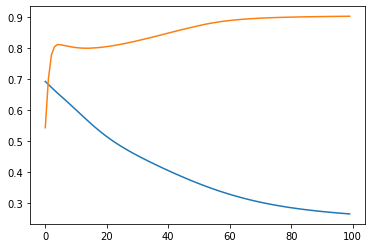

In [15]:
loss_arr = []
acc_arr = []
for e in range(epochs):
    label_pred = model(training_input)
    loss = loss_fn(label_pred, training_labels.reshape(-1, 1))
    val_pred = model(val_input)
    acc_arr.append(1 - torch.sum(torch.abs(model(val_input).round() - val_labels.reshape(-1, 1))).item()/len(val_labels))
    loss_arr.append(loss.item())
    if e % 50 == 0:
        print(e, loss.item())
        print(model(val_input))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
plt.plot(range(epochs), loss_arr)
plt.plot(range(epochs), acc_arr)
plt.show()

In [ ]:
print(1 - torch.sum(model(val_input).round() - val_labels.reshape(-1, 1)).item()/len(val_labels))